#### Experiment (I). Hiearhical Counting

In [1]:
# The issue with this counting sequence is that it has batch size of 1 only 
# it's fine for now, but clearly a fourier series decomposition is more beautiful

# (I). Counting Sequence
# --------------------------------------------------------------------------------
from collections import defaultdict
import torch

# (I.1) Generate Counting Sequence
# ----------------------------------------------------
def generate_level(l: int, seq: list, t: int, L: int, K: int): 
    if l < L:
        seq[l] += str(l)
        if t % K == 0: 
            return generate_level(l+1, seq, t // K, L, K)
    return seq

def generate_count_seq(L: int, K: int, T: int): 
    seq = defaultdict(str)
    for t in range(1, T+1): 
        seq = generate_level(0, seq, t, L, K)
    return seq
# ----------------------------------------------------

# (I.2) Tokenizer (basic integer tokenizer)
# ----------------------------------------------------

class TinyTokenizer: 
    def __init__(self, vocab: dict):
        self.vocab = {str(k): v for k, v in vocab.items()}
        self.vocab_size = len(vocab)

    def __call__(self, seq: str):
        return [self.vocab[c] for c in seq]

# ----------------------------------------------------


# (I.3) Tensor idx sequence preparation 
# ----------------------------------------------------

L = 3
K = 2
T = 200

data = generate_count_seq(L, K, T)
tokenizer = TinyTokenizer({str(k): k for k in range(10)})

idx = [tokenizer(seq) for seq in data.values()]
idx += [[] for _ in range(L - len(idx))]
samples = [(idx, None)]

from model import GATConfig, GAT, HierSeq
from utils import stream_print_hseq
from torch.optim import Adam 

config = GATConfig(K=K, L=L, n_embd=128, n_head=4, device="cpu", _compile=False)
gat = GAT(config)

# .from_hiearchical_data has error: prepared token is NOT interleaved with correct causal ordering
batch_data = HierSeq.from_hierarchical_data(samples, K=gat.K, L=gat.L)
stream_print_hseq(batch_data) # sanity check

# Batched Forward Propagation
epochs = 30
# gat.train()


# Training Loop : learning just fine -- loss reduces quickly
# ----------------------------------------------------
optimizer = Adam(gat.parameters(), lr=1e-3)

for epoch in range(epochs):
    loss = gat(batch_data)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
    # break
# ----------------------------------------------------


Hierarchical Sequence K=2 L=3 (aligned by timestamp):
-------------------------------------------------------
Level 2:                 [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2] 
Level 1:         [1]     [1]     [1]     [1]     [1]     [1]     [1]     [1

In [2]:
from utils import * 


test_data = generate_count_seq(L, K, 1)
idx = [tokenizer(seq) for seq in test_data.values()]
idx += [[] for _ in range(L - len(idx))]
test_samples = [(idx, None)]
test_batch_data = HierSeq.from_hierarchical_data(test_samples, K=gat.K, L=gat.L)


for _ in range(25): 
    gat.generate(test_batch_data)
    stream_print_hseq(test_batch_data)
    time.sleep(0.5)


Hierarchical Sequence K=2 L=3 (aligned by timestamp):
-------------------------------------------------------
Level 2:                 [2]             [2]             [2]                 
Level 1:         [1]     [1]     [1]     [1]     [1]     [1]     [1]         
Level 0:     [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] 
Total tokens: 26, Max timestamp: 16



#### Self-Organizing Reinforcement Learning
1. A more exciting question is how can I build a GAT module for a Snake game? It'll be the natural test-bed for SoRL -- a snake with inner-monologue. 
2. Decision Abstractive Transformer (DAT).


In [1]:
from snake import SnakeGameEngine, collect_trajectories, RandomAgent
from utils import HierTraj, data_sanity_check
from constant import PLACE_HOLDER_STATE_TOK, PLACE_HOLDER_ACTION_TOK

env = SnakeGameEngine(width=10, height=10)

# This is a make-shift data collection pipeline, the abstract tokens are complete false. 
# The proper way to collect data, per SoRL, is to 'simulate' multiple actions on the environment and store the HierTraj state directly
# in that sense, the code snippet in the middle is not useful...

# A way to use 'expert trajectory' is to take in the 'trajectories', and have the agent 'learn / explore' on what abstract tokens can be 
# used to explain the trajectory. This is very similar to the 'intuitive-physics' based 'learning by surprise' or 'active learning from obs' 
# idea. 

# For what is worth, the mid-snippet is useless (besides serving as a toy-case on which we test on SSL training of GAT)

# Collect trajectories
trajectories = collect_trajectories(env, RandomAgent(env), num_episodes=5, device="cpu")

samples = []
for trajectory in trajectories: 

    n_state = trajectory[0].size(0)
    placeholder_tokens = [PLACE_HOLDER_STATE_TOK if i % 2 == 0 else PLACE_HOLDER_ACTION_TOK for i in range(2*n_state-1)]
    sample = ([placeholder_tokens, [3, 9, 4, 2], [19, 14]], None)
    samples.append(sample)

batch_data = HierTraj.from_hierarchical_data(samples, K=3, L=3)
data_sanity_check(batch_data, trajectories)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
Episode 0: Score=0, Reward=-11.0
Episode 1: Score=0, Reward=-10.9
Episode 2: Score=0, Reward=-10.9
Episode 3: Score=1, Reward=-0.7999999999999989
Episode 4: Score=0, Reward=-13.200000000000001
Sanity check passed: total 153 0-th level tokens (state & action)
Sanity check passed: 79 state tokens in data, 79 state tokens in trajectories
Sanity check passed: 74 action tokens in data, 74 action tokens in trajectories
Sanity check passed: 183 (action/state/abstract) tokens in data


In [2]:
from model import DAT, DATConfig

# DAT model 

config = DATConfig(
    n_layer=4,
    n_head=2,
    n_embd=32,
    K=2,
    L=3,
    vocab_size_list=[64, 32],
    device="cpu",
    _compile=True,
)

# Snake specific encoder & decoder for state & action
from snake import StateEncoder, StateDecoder, ActionEncoder, ActionDecoder

state_encoder = StateEncoder(height=10, width=10, feature_dim=config.n_embd)
state_decoder = StateDecoder(height=10, width=10, feature_dim=config.n_embd)
action_encoder = ActionEncoder(action_size=4, feature_dim=config.n_embd)
action_decoder = ActionDecoder(action_size=4, feature_dim=config.n_embd)

dat = DAT(config, state_encoder, state_decoder, action_encoder, action_decoder)

In [3]:
# compute loss
loss = dat(batch_data, trajectories)

# generate & update 
new_batch_data, new_trajectories = dat.generate(batch_data, trajectories)

# act: produce action tokens (if there already exists action-tokens un-grounded with reward, skip it)
pairs = dat.act(batch_data, trajectories) # list of (sample_idx, action_idx)


In [4]:
# Validate on 'order of generation'
from utils import test_dat_gen_order

# Sanity check-up function (order of generation)
test_dat_gen_order(dat, env, L=3, K=2, n_gen=10)


Hierarchical Trajectory K=2 L=3 (aligned by timestamp):
-------------------------------------------------------
Level 2:              [0]     
Level 1:      [0]     [0]     
L0-State: [s] [s] [s] [s]     
L0-Action:    [a] [a] [a] [a] 
Total tokens: 11, Max timestamp: 4



In [ ]:
# Create 2x2 visualization for first 4 samples
# --------------------------------------------------------------

from vis import visualize_backtrack
from utils import * 
import matplotlib.pyplot as plt

# Create 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Backtrack Visualization for First 4 Samples', fontsize=16)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Process first 4 samples
num_samples = min(4, batch_data.indices.max().item() + 1)

for i in range(num_samples):
    sample_idx = i
    
    # Get sample-level perplexity data
    per_sample_ppt, per_sample_timestamps, max_abs_ts = get_sample_level_ppl(batch_data, ppt, level=0)
    
    # Extract data for current sample
    sample_timestamps = per_sample_timestamps[sample_idx][:max_abs_ts + batch_data.K]
    sample_ppt = per_sample_ppt[sample_idx][:max_abs_ts + batch_data.K]
    
    # Select current subplot
    ax = axes_flat[i]
    
    # Plot the data
    ax.plot(sample_timestamps.cpu().numpy(), sample_ppt.cpu().numpy(), 
            'b-', linewidth=1.5, label='Perplexity')
    
    # Add threshold line
    ax.axhline(y=buffer.ppl_thres, color='r', linestyle='--', 
               linewidth=1, label=f'Threshold ({buffer.ppl_thres:.2f})')
    
    # Mark critical timestamps
    critical_mask = sample_ppt > buffer.ppl_thres
    if critical_mask.any():
        critical_ts = sample_timestamps[critical_mask]
        critical_ppt = sample_ppt[critical_mask]
        ax.scatter(critical_ts.cpu().numpy(), critical_ppt.cpu().numpy(), 
                  color='red', s=50, zorder=5, label='Critical Points')
    
    # Mark backtrack points (where cts changed for this sample)
    if sample_idx < len(cts):
        backtrack_ts = cts[sample_idx] + 1
        if backtrack_ts > 0:
            ax.axvline(x=backtrack_ts, color='green', linestyle=':', 
                      linewidth=1.5, label=f'Backtrack (t={backtrack_ts})')
    
    # Styling
    ax.set_xlabel('Timestamp', fontsize=10)
    ax.set_ylabel('Perplexity', fontsize=10)
    ax.set_title(f'Sample {sample_idx}', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='upper right')
    
    # Set y-axis limits for better visualization
    ax.set_ylim([0, max(10, sample_ppt.max().item() * 1.1)])

# Hide unused subplots if less than 4 samples
for i in range(num_samples, 4):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Visualized {num_samples} samples in 2x2 grid")


In [ ]:
# Use the new helper function for cleaner multi-sample visualization
from vis import visualize_multi_sample_backtrack

# Create 2x2 grid visualization for first 4 samples
fig, axes = visualize_multi_sample_backtrack(batch_data, ppt, cts, buffer, num_samples=4)
plt.show()


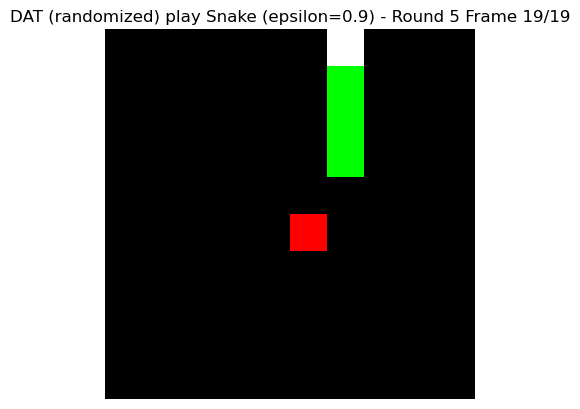

: 

In [ ]:
# Does DAT dream of playing snake game?

# from agent import HiearchicalAgent
from snake import SnakeGameEngine
from utils import draw_gif
from agent import collect_dat_game_play_frames
from agent import HiearchicalAgent

# Environment
env = SnakeGameEngine(width=10, height=10)

# DAT Agent (Snake specific agent)
# agent = HiearchicalAgent(dat, env.reset(), "cpu")

# DAT plays the snake game
# --------------------------------------------------------------------------------------------------------------------------
epsilon = 0.9
frames = collect_dat_game_play_frames(dat, env, epsilon=epsilon)
draw_gif(frames, txt=f"DAT (randomized) play Snake (epsilon={epsilon})", path="./visual/dat_snake.gif")

Training Algorithm

- Learn to Explain (GAT)
Trajectory only data --> Sample --> Train

- Learn to Explore (DAT)
No data --> Sample --> Extend & Environment Interaction --> Train

$\textbf{SoRL (GAT)}$
1. Group advantage computation 
2. Surrogate loss computation

The key for learning from experience is learning from failure

In [49]:
# learn-to-explain (GAT) | one batch ver.

# (1). Initialize Data Buffer with trajectory-only data 

from model import GATConfig, GAT, HierSeq
from utils import *
from torch.optim import Adam 
import random 

L, K = 3, 2
config = GATConfig(K=K, L=L, n_embd=128, n_head=4, device="cpu", _compile=False)
gat = GAT(config)

# - samples without abstract tokens, trajectory data only
samples = [([[0]*random.randint(4, 10)] + [[] for l in range(1, config.L)],None) for _ in range(2)]
batch_data = HierSeq.from_hierarchical_data(samples, K=gat.K, L=gat.L)

In [15]:
# Abstract learning for GAT (one batch ver.)
# --------------------------------------------------------------------------------------------------------------------------
from search import eval_hseq

optimizer = Adam(gat.parameters(), lr=1e-3)
t_search = 2
critical_ts = None
temperature = 1.0
epochs = 80

# Issue with training loop: 
# 1. Control ratio is not 1.0, this might not be possible when temperature remains at 1.0 -- how about dropping temperature gradually? 
# 2. 

for epoch in range(epochs):
    
    pad_abstract_tokens(batch_data, critical_ts, t_search)
    gat.generate(batch_data, parallel=True, temperature=temperature)
    # Error must be here, ts computation logic is off
    p_per_sample, critical_ts, cr, ppt = eval_hseq(gat, batch_data, p_thres=0.5)
    for b in range(batch_data.batch_size): 
        print(f" - Control Ratio: {cr[b]} perplexity: {p_per_sample[b]}, critial timestamps: {critical_ts[b]}")

    loss = gat(batch_data)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

 - Control Ratio: 0.1666666716337204 perplexity: 4.505456447601318, critial timestamps: 1
 - Control Ratio: 0.1666666716337204 perplexity: 4.505456924438477, critial timestamps: 1
Epoch 1/80, Loss: 4.505456924438477
 - Control Ratio: 0.1666666716337204 perplexity: 4.420316219329834, critial timestamps: 1
 - Control Ratio: 0.1666666716337204 perplexity: 4.421609878540039, critial timestamps: 1
Epoch 2/80, Loss: 4.420963287353516
 - Control Ratio: 0.1666666716337204 perplexity: 4.288652420043945, critial timestamps: 1
 - Control Ratio: 0.1666666716337204 perplexity: 4.290994167327881, critial timestamps: 1
Epoch 3/80, Loss: 4.289823532104492
 - Control Ratio: 0.1666666716337204 perplexity: 4.174693584442139, critial timestamps: 1
 - Control Ratio: 0.1666666716337204 perplexity: 4.176031589508057, critial timestamps: 1
Epoch 4/80, Loss: 4.175362586975098
 - Control Ratio: 0.1666666716337204 perplexity: 4.068854808807373, critial timestamps: 1
 - Control Ratio: 0.1666666716337204 perplexit

Algorithm: 
1. Naive Search: every time we search from scratch, generate abstraction for certain timesteps and learn. Rely on model's growing capacity to increase the search timestamps nextly. This means no storing, no caching of intermediate results, most similar to GRPO, but with special treatment for incremental searching mechanism. 

In [118]:
# Util functions 
# ----------------------------------

def pad_abstract_tokens(batch_data: HierSeq, t_search: int = 8): 
    abstract_mask = (batch_data.levels > 0)
    assert not abstract_mask.any(), " - Abstract tokens already exist, 'pad_abstract_tokens' requires no abstract tokens"

    for sample_idx in batch_data.indices: 
        sample_mask = batch_data.sample_idx == sample_idx
        sample_timestamps = batch_data.timestamps[sample_mask]
        start_ts, end_ts = sample_timestamps[0], sample_timestamps[-1]

        for l in range(1, batch_data.L): 
            abs_tok_ts = torch.arange(start_ts - 1, end_ts, batch_data.K ** l)
            batch_data.insert_tokens(sample_idx, MASK_TOK, l, abs_tok_ts[abs_tok_ts >= start_ts])

    return batch_data


def repeat_hseq(batch_data: HierSeq, n_copies: int): 

    original_batch_size = batch_data.batch_size

    replicated_tokens = batch_data.tokens.repeat(n_copies)
    replicated_levels = batch_data.levels.repeat(n_copies)  
    replicated_timestamps = batch_data.timestamps.repeat(n_copies)

    tokens_per_sample = torch.bincount(batch_data.sample_idx)[batch_data.indices]  # [num_tokens_sample_0, num_tokens_sample_1, ...]
    repeats = tokens_per_sample.repeat(n_copies) 
    new_sample_idx = torch.repeat_interleave(
        torch.arange(original_batch_size * n_copies),
        repeats
    )

    unique_original_indices = batch_data.sample_idx.unique(sorted=True)  # Get actual unique sample indices
    idx_map = {}
    for rep_idx, orig_idx in enumerate(unique_original_indices.repeat(n_copies)): 
        idx_map[rep_idx] = orig_idx.item()
        
    replicated_batch_data = HierSeq(
        tokens=replicated_tokens,
        levels=replicated_levels,
        timestamps=replicated_timestamps,
        sample_idx=new_sample_idx,
        batch_size=original_batch_size * n_copies,
        K=batch_data.K,
        L=batch_data.L,
        idx_map=idx_map
    )

    return replicated_batch_data

def compute_per_sample_rewards(level_ppt: torch.Tensor, level_idx: torch.Tensor): 
    
    unique_samples, inverse = torch.unique(level_idx, return_inverse=True)

    n_unique = len(unique_samples)
    sums = torch.zeros(n_unique).scatter_add_(0, inverse, level_ppt)
    counts = torch.bincount(inverse, minlength=n_unique).float()
    averages = - sums / counts # reward is minus perplexity value

    lookup = {s.item(): avg for s, avg in zip(unique_samples, averages)}
    return lookup 

def compute_hierarchical_rewards(ppt: torch.Tensor, repeat_batch: HierSeq) -> dict: 
    """ 
    abstraction level l is rewarded when it improves the perplexity of level l-1 tokens
    """
    traj_mask = (repeat_batch.levels[1:] == 0) & (repeat_batch.timestamps[1:] > 0)
    traj_ppt = ppt[traj_mask]
    traj_idx = repeat_batch.sample_idx[1:][traj_mask]

    reward_lookups = {}

    reward_lookups[0] = None

    current_level_ppt = traj_ppt
    current_level_idx = traj_idx

    for level in range(1, repeat_batch.L):
        # Compute per-sample average of current level
        sample_rewards = compute_per_sample_rewards(current_level_ppt, current_level_idx)
        reward_lookups[level] = sample_rewards
        
        # Prepare for next level (if exists)
        if level < repeat_batch.L - 1:
            next_mask = (repeat_batch.levels[1:] == level) & (repeat_batch.timestamps[1:] > 0)
            current_level_ppt = ppt[next_mask]
            current_level_idx = repeat_batch.sample_idx[1:][next_mask]

    return reward_lookups 


def compute_grouped_advantage(values: torch.Tensor, indices: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """Grouped advantage using indices to group values tensor"""
    
    unique, inverse = torch.unique(indices, return_inverse=True)
    n = len(unique)

    means = torch.zeros(n).scatter_add_(0, inverse, values) / torch.bincount(inverse).float()
    vars = torch.zeros(n).scatter_add_(0, inverse, values**2) / torch.bincount(inverse).float() - means**2
    stds = torch.sqrt(torch.clamp(vars, min=0))

    advantages = (values - means[inverse]) / (stds[inverse] + 1e-4)

    return advantages

def _compute_log_probs(ppt: torch.Tensor, repeat_batch: HierSeq) -> list:
    old_log_probs = [None]
    for l in range(1, repeat_batch.levels.max() + 1):
        level_ppt_mask = (repeat_batch.levels[1:] == l) & (repeat_batch.timestamps[1:] > 0)
        old_level_ppt = ppt[level_ppt_mask] # per-token-log-probability of un-updated model
        old_log_probs.append(old_level_ppt)
    return old_log_probs

def generate_rollout_data(old_model: GAT, ref_model: GAT,  
                          batch_data: HierSeq, n: int, t_search: int, 
                          temperature: float): 

    repeat_batch = repeat_hseq(batch_data, n)

    pad_abstract_tokens(repeat_batch, t_search) 

    # generate rollout 
    repeat_batch = old_model.generate(repeat_batch, parallel=True, temperature=temperature)

    # compute log_probs
    ppt = old_model(repeat_batch)
    old_log_probs = _compute_log_probs(ppt, repeat_batch) # per-level log probs

    # compute reference log_probs
    ref_ppt = ref_model(repeat_batch)
    ref_log_probs = _compute_log_probs(ref_ppt, repeat_batch) # per-level log probs

    return repeat_batch, old_log_probs, ref_log_probs

def compute_grpo_loss(repeat_batch: HierSeq, ppt: torch.Tensor,
                      old_log_probs: list, ref_log_probs: list, 
                      epsilon: float = 0.2, beta: float = 0.1):
        
    # per-level sample_idx->reward lookup table | detach makes sense?
    reward_lookups = compute_hierarchical_rewards(ppt.detach(), repeat_batch)

    loss = torch.tensor(0.0, device=repeat_batch.tokens.device)

    for l in range(1, repeat_batch.L): 
        level_ppt_mask = (repeat_batch.levels[1:] == l) & (repeat_batch.timestamps[1:] > 0)
        new_level_ppt = ppt[level_ppt_mask] 
        old_level_ppt = old_log_probs[l] # loaded from rollout data

        if len(old_level_ppt) == 0: 
            continue 

        # Compute level l reward for each sample with abstraction at level l
        level_sample_idx = repeat_batch.sample_idx[1:][level_ppt_mask]
        sample_with_level_l = repeat_batch.indices[torch.isin(repeat_batch.indices, level_sample_idx)]

        sample_level_rewards = torch.tensor(
            [reward_lookups[l][idx.item()] for idx in sample_with_level_l],
            device=repeat_batch.tokens.device
        )
        orig_idx = torch.tensor(
            [repeat_batch.idx_map[idx.item()] for idx in sample_with_level_l],
            device=repeat_batch.tokens.device
        )

        sample_level_advantages = compute_grouped_advantage(sample_level_rewards, orig_idx)

        sample_to_advantage = {
            sample_idx.item(): adv.item() 
            for sample_idx, adv in zip(sample_with_level_l, sample_level_advantages)
        }

        advantages = torch.tensor(
            [sample_to_advantage[idx.item()] for idx in level_sample_idx],
            device=repeat_batch.tokens.device
        )

        ratio = torch.exp(new_level_ppt - old_level_ppt)

        # Compute surrogate loss
        surrogate_loss = torch.min(ratio * advantages, torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantages)

        # Compute KL divergence between reference & new log_probs
        log_ratio = ref_log_probs[l] - new_level_ppt
        kl = torch.exp(log_ratio) - log_ratio - 1

        # Compute per-token loss
        per_token_loss = surrogate_loss - beta * kl

        loss_abs_l = - per_token_loss.mean()

        loss += loss_abs_l

    return loss  


def compute_ssl_loss(repeat_batch: HierSeq, ppt: torch.Tensor): 

    traj_mask =(repeat_batch.levels[1:] == 0) & (repeat_batch.timestamps[1:] > 0)
    traj_ppt = ppt[traj_mask]

    ssl_loss = traj_ppt.mean()

    return ssl_loss

In [219]:
# Surrogate loss computation refernece (GRPO)
# - we need reward for each abstract token
# - we compute avg reward for each sample (over all its abstract tokens)
# - we compute mean / std of rewards for multiple abstractions corresponding to the same original sample
# - we calculate advantage term for each repeated sample
# - this provides 'abstraction sequence' level advantage
# - compute policy gradient loss for each abstraction token

# Question: can we compute per-abstract-token advantage? Well we have but one sample in terms of each abstract token 
#           so advantage can't be approxiamted here. 

# Note: GRPO requires a reference model to avoid strong deviation

# We shall compute a reference free (kl regularization free) loss first in here. 

# Note: we need to store 'rollout data' and 'old-log-probs' for each sample .... how is that possible with new abstractions?

# ratio = torch.exp(new_log_probs - old_log_probs)
# rewards = rewards.view(batch_size, num_generations)
# avg_reward = rewards.mean().item() 
# mean_rewards = rewards.mean(dim=1).repeat_interleave(num_generations)
# std_rewards = rewards.std(dim=1).repeat_interleave(num_generations)
# advantages = ((rewards.view(-1) - mean_rewards) / (std_rewards + 1e-4)).unsqueeze(1)
# surrogate_loss = torch.min(ratio * advantages, torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantages)
# kl = torch.exp(ref_log_probs - new_log_probs) - (ref_log_probs - new_log_probs) - 1
# per_token_loss = surrogate_loss - beta * kl
# loss = - ((per_token_loss * completion_mask).sum(dim=1) / completion_mask.sum(dim=1)).mean()


# ratio = torch.exp(new_log_probs - old_log_probs)
# surrogate_loss = torch.min(ratio * advantages, torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantages)
# loss = - ((per_token_loss * completion_mask).sum(dim=1) / completion_mask.sum(dim=1)).mean()


In [119]:
# (I). "generate_rollout_data" function
#    - generate rollout, compute (detached) old_log_probs for each level's abstraction

n = 4 # number of generations for each sample
t_search = 4 
temperature = 1.0

with torch.no_grad(): 
    repeat_batch, old_log_probs, ref_log_probs = generate_rollout_data(gat, gat, 
    batch_data, n, t_search, temperature)

In [120]:
# (II). "compute_grpo_loss" function | load rollout data & old_log_probs
epsilon = 0.2 

ppt = gat(repeat_batch)

# RL loss for abstract tokens (no reference model ver.)
grpo_loss = compute_grpo_loss(repeat_batch, ppt, old_log_probs, ref_log_probs, epsilon)

# SSL loss for trajectory tokens
ssl_loss = compute_ssl_loss(repeat_batch, ppt)

Training Loop

In [ ]:
# Benchmark RL & SSL combination strategies 
# -------------------------------------------------------------
import copy 

num_iterations = 10 
num_steps = 100
grpo_steps = 10

for iteration in range(num_iterations): 
    print(f"\nIteration {iteration+1}/{num_iterations}")

    ref_model = copy.deepcopy(gat)
    ref_model.eval() 
    for param in ref_model.parameters(): 
        param.requires_grad = False
    print("Reference model created")

    optimizer = torch.optim.Adam(gat.parameters(), lr=1e-3)
    gat.train() 

    for step in range(num_steps): 
        print(f"\nStep {step+1}/{num_steps}")
        # (Missing) Random sample from 'dataset', use 'batch_data' directly

        with torch.no_grad(): 
            repeat_batch, old_log_probs, ref_log_probs = generate_rollout_data(gat, ref_model, 
                                                                                batch_data, n, t_search, temperature)
            print("\n\n------------------------ \n Example abstraction: \n", repeat_batch.tokens[repeat_batch.levels > 0][:15])
            # Clear cache after generating rollouts
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
       
        for grpo_iter in range(grpo_steps): 
            print(f"GRPO inner loop {grpo_iter+1}/{grpo_steps}")
            ppt = gat(repeat_batch)
            grpo_loss = compute_grpo_loss(repeat_batch, ppt, old_log_probs, ref_log_probs)
            ssl_loss = compute_ssl_loss(repeat_batch, ppt)

            loss = grpo_loss + ssl_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"GRPO loss: {grpo_loss.item()}, SSL loss: {ssl_loss.item()}, Total loss: {loss.item()}")

            # Clear cache after each iteration
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            print(f"Iteration {iteration+1}/{num_iterations}, Step {step+1}/{num_steps}, "
                      f"GRPO iter {grpo_iter+1}/{grpo_steps}, loss: {loss.item():.4f}, grpo_loss: {grpo_loss.item():.4f}, ssl_loss: {ssl_loss.item():.4f}")

            del loss 
    


Iteration 1/10
Reference model created

Step 1/100


------------------------ 
 Example abstraction: 
 tensor([50, 46, 27, 11,  1, 52, 20, 37,  4, 37, 12, 58, 60, 46, 13])
GRPO inner loop 1/10
GRPO loss: 1.7881393432617188e-07, SSL loss: 3.881624460220337, Total loss: 3.881624698638916
Iteration 1/10, Step 1/100, GRPO iter 1/10, loss: 3.8816, grpo_loss: 0.0000, ssl_loss: 3.8816
GRPO inner loop 2/10
GRPO loss: -0.036985136568546295, SSL loss: 3.783885955810547, Total loss: 3.746900796890259
Iteration 1/10, Step 1/100, GRPO iter 2/10, loss: 3.7469, grpo_loss: -0.0370, ssl_loss: 3.7839
GRPO inner loop 3/10
GRPO loss: -0.15564623475074768, SSL loss: 3.5311005115509033, Total loss: 3.3754541873931885
Iteration 1/10, Step 1/100, GRPO iter 3/10, loss: 3.3755, grpo_loss: -0.1556, ssl_loss: 3.5311
GRPO inner loop 4/10
GRPO loss: -0.26130300760269165, SSL loss: 3.319312334060669, Total loss: 3.058009386062622
Iteration 1/10, Step 1/100, GRPO iter 4/10, loss: 3.0580, grpo_loss: -0.2613, ssl_loss

In [ ]:
# I need a conversion from 'sample_idx' to 'abstract_indices'
# for instance, 0th sample contains 2 abstract tokens (level l), 1st sample contains 4 abstract tokens (level l)
# then, the broadcast of per-sample advantages should be done as 
# [advantage_sample_0, advantage_sample_1] -> [advantage_sample_0, advantage_sample_0, advantage_sample_1, advantage_sample_1, advantage_sample_1, advantage_sample_1]



In [ ]:
from dataset.nbody import * 
from utils import * 
from buffer import * 
from model import GATConfig, GAT, HierSeq
from torch.optim import Adam 

L, K = 3, 2
config = GATConfig(K=K, L=L, n_embd=128, n_head=4, device="cpu", _compile=False)
gat = GAT(config)

# Build Dataset 
dataset = create_dataset_with_params(
    n_bodies=2,
    patterns=['cartesian'],
    n_context=3,
    stride=1,
    T=10,
    include_masses=True,
)

# Initialize Tokenizer 
tokenizer = TinyTokenizer()

# Initialize Buffer
samples, timestamps = [], [] 
for seq in dataset['sequences']:
    s = tokenizer(seq)
    ts = [[t for t in range(1, len(s)+1)]] + [[] for l in range(1, config.L)]
    s = [s] + [[] for l in range(1, config.L)]
    samples.append((s))
    timestamps.append(ts)

# pop_size = 2
# write_shard('dataset/nbody/buffer_b.bin', samples[:pop_size], timestamps[:pop_size])